# New section

# New section

# New section

In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta

# Générer des adresses IP russes (plages courantes : 95.31.x.x, 87.251.x.x, etc.)
def generate_russian_ip():
    return f"95.31.{random.randint(0, 255)}.{random.randint(0, 255)}"

# Générer des logs réseau
logs = []
for _ in range(1000):
    timestamp = datetime.now() - timedelta(minutes=random.randint(0, 1440))
    source_ip = generate_russian_ip() if random.random() > 0.3 else f"{random.randint(100, 200)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}"
    label = "normal" if "95.31" in source_ip else "brute_force"  # Simuler des attaques depuis l'étranger
    logs.append({
        "timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S"),
        "source_ip": source_ip,
        "destination_port": 22,
        "protocol": "SSH",
        "bytes_sent": random.randint(100, 150),
        "country_code": "RU" if "95.31" in source_ip else random.choice(["DE", "US", "CN"]),
        "label": label
    })

# Créer un DataFrame et sauvegarder en CSV
df = pd.DataFrame(logs)
df.to_csv("network_logs_ru_synthetic.csv", index=False)

In [ ]:
df

,timestamp,source_ip,destination_port,protocol,bytes_sent,country_code,label
0,2025-04-16 22:57:16,95.31.252.187,22,SSH,150,RU,normal
1,2025-04-16 14:37:16,95.31.36.13,22,SSH,150,RU,normal
2,2025-04-17 03:13:16,148.141.145.10,22,SSH,146,CN,brute_force
3,2025-04-17 02:50:16,195.133.202.80,22,SSH,118,US,brute_force
4,2025-04-16 18:20:16,158.56.211.12,22,SSH,143,US,brute_force
...,...,...,...,...,...,...,...
995,2025-04-16 14:46:16,95.31.250.194,22,SSH,135,RU,normal
996,2025-04-16 21:33:16,172.5.16.177,22,SSH,119,CN,brute_force
997,2025-04-17 04:10:16,102.251.95.152,22,SSH,104,CN,brute_force
998,2025-04-16 22:22:16,95.31.25.41,22,SSH,149,RU,normal


In [ ]:
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
data= pd.read_csv("trafic.csv")

In [ ]:
data.head(n=4)

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,172.16.63.139,192.248.168.217,TCP,1514,58727 > 22222 [ACK] Seq=1 Ack=1 Win=513 Len=...
1,2,0.000000,172.16.63.139,192.248.168.217,TLSv1.2,891,Application Data
2,3,0.000207,172.16.63.139,192.248.168.217,TCP,1514,58727 > 22222 [ACK] Seq=2298 Ack=1 Win=513 L...
3,4,0.000207,172.16.63.139,192.248.168.217,TLSv1.2,623,Application Data


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Charger les données
df = pd.read_csv("trafic.csv")

# Nettoyer les colonnes inutiles
df = df.drop(["No.", "Info"], axis=1)

# Encoder les variables catégorielles (ex: Protocol, Source, Destination)
label_encoders = {}
for col in ["Source", "Destination", "Protocol"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Pour inverser plus tard

# Extraire des features temporelles
df["Time"] = df["Time"].astype(float)
df["Time_Interval"] = df["Time"].diff().fillna(0)  # Intervalle entre les paquets

# Normalisation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[["Length", "Time_Interval"]])

In [ ]:
scaled_data

array([[ 1.16939058, -0.16495449],
       [ 0.25134017, -0.16495449],
       [ 1.16939058, -0.16246475],
       ...,
       [ 1.16939058, -0.16495449],
       [-0.98205982, -0.16460568],
       [ 0.88793371, -0.12426466]])

In [ ]:
# Features pertinentes
features = ["Source", "Destination", "Protocol", "Length", "Time_Interval"]
X = pd.DataFrame(scaled_data, columns=["Length", "Time_Interval"])
X["Protocol"] = df["Protocol"]

In [ ]:
from sklearn.ensemble import IsolationForest

# Entraîner le modèle
model = IsolationForest(
    n_estimators=100,
    contamination=0.05,  #% de données considérées comme anomalies
    random_state=42
)
model.fit(X)

# Prédire les anomalies
df["Anomaly_Score"] = model.decision_function(X)
df["Is_Anomaly"] = model.predict(X)  # -1 = anomalie, 1 = normal

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from tensorflow.keras import layers, models

# B. Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof.fit_predict(X)

# C. One-Class SVM
svm = OneClassSVM(nu=0.05, kernel="rbf")
svm_pred = svm.fit_predict(X)


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [ ]:
import numpy as np
# D. Autoencodeur (Keras)
encoder = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    layers.Dense(32, activation='relu')
])
decoder = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(32,)),
    layers.Dense(X.shape[1], activation='linear')
])
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=50, batch_size=256)
recon_errors = np.mean(np.square(X - autoencoder.predict(X)), axis=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5.8705
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2101 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5326 
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0966 
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 
Epoch 13/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 14/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2971e-04 
Epoch 15/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6503e-04 
Epoch 16/

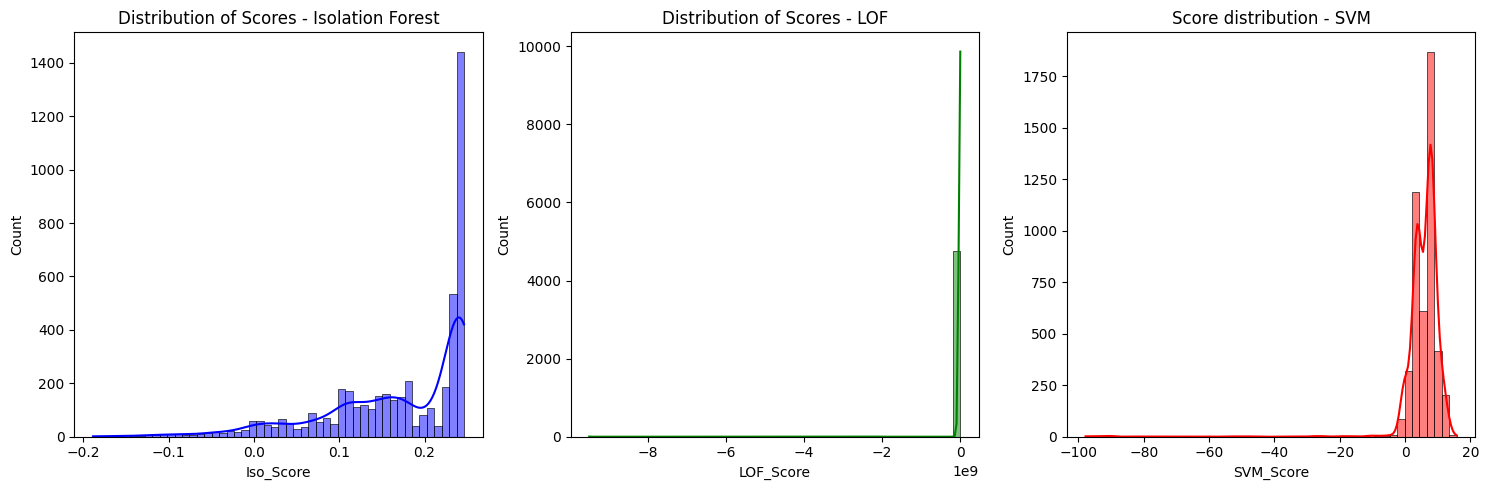

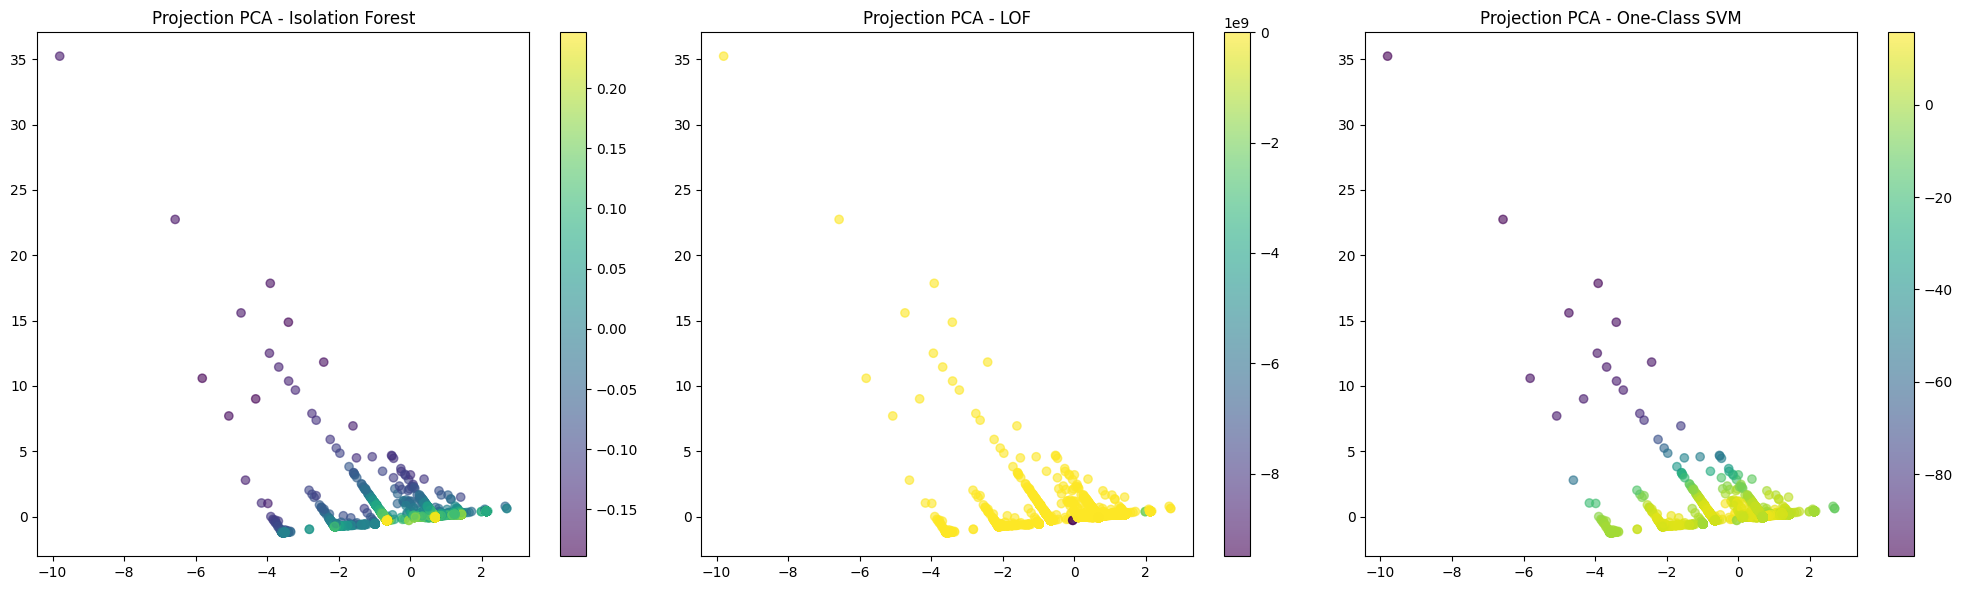

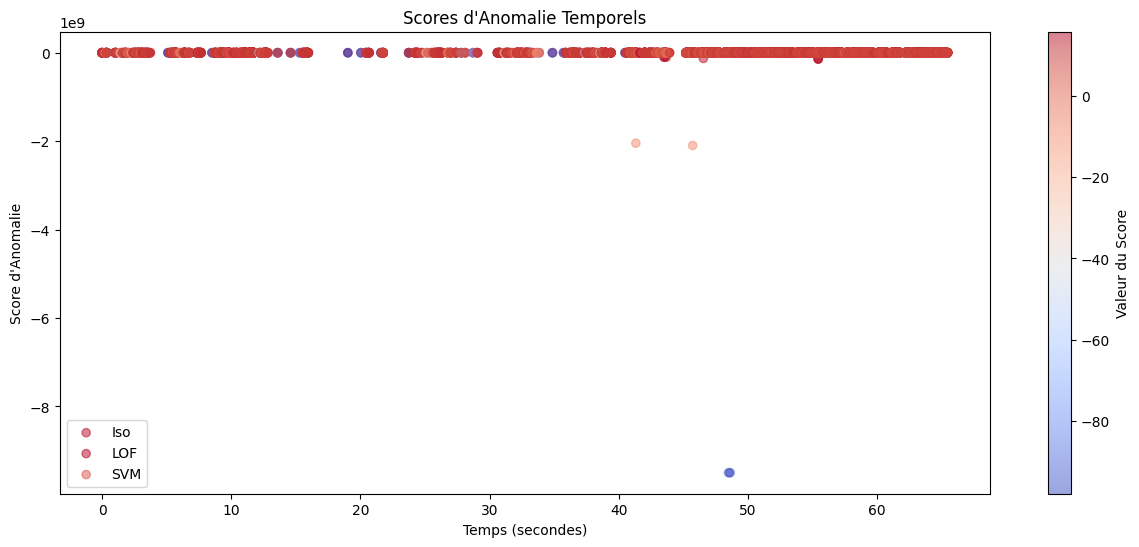


Comparaison des Performances :
| Modèle           |   % Anomalies |   Écart-Type Scores |   Skewness |
|:-----------------|--------------:|--------------------:|-----------:|
| Isolation Forest |     0.0234702 |         0.0855382   |   -1.16859 |
| LOF              |     0.0500838 |         1.99072e+08 |  -45.974   |
| One-Class SVM    |     0.0500838 |         7.19466     |   -9.50445 |


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# Supposons que nous ayons :
# - X : données préprocessées
# - y_true : labels réels (si disponibles)
# - Modèles déjà entraînés : iso_model, lof_model, svm_model

# 1. Calcul des scores d'anomalie
df["Iso_Score"] =  model.decision_function(X)
df["LOF_Score"] =  lof.negative_outlier_factor_  # Conversion des scores LOF
df["SVM_Score"] =   svm.decision_function(X)  # Inversion pour cohérence

# 2. Visualisation des distributions de scores
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(df["Iso_Score"], bins=50, kde=True, color='blue')
plt.title("Distribution of Scores - Isolation Forest")

plt.subplot(132)
sns.histplot(df["LOF_Score"], bins=50, kde=True, color='green')
plt.title("Distribution of Scores - LOF")

plt.subplot(133)
sns.histplot(df["SVM_Score"], bins=50, kde=True, color='red')
plt.title("Score distribution - SVM")

plt.tight_layout()
plt.show()

# 3. Projection PCA comparée
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = {
    "Isolation Forest": df["Iso_Score"],
    "LOF": df["LOF_Score"],
    "One-Class SVM": df["SVM_Score"]
}

for ax, (name, scores) in zip(axes, models.items()):
    scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=scores, cmap='viridis', alpha=0.6)
    ax.set_title(f"Projection PCA - {name}")
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.show()

# 4. Analyse temporelle des anomalies
plt.figure(figsize=(15, 6))

for model, color in zip(["Iso_Score", "LOF_Score", "SVM_Score"], ['blue', 'green', 'red']):
    plt.scatter(df["Time"], df[model],
                c=df[model], cmap='coolwarm',
                alpha=0.5, label=model.split('_')[0])

plt.title("Scores d'Anomalie Temporels")
plt.xlabel("Temps (secondes)")
plt.ylabel("Score d'Anomalie")
plt.legend()
plt.colorbar(label='Valeur du Score')
plt.show()


# 5. Métriques de performance (si y_true disponible)
if 'y_true' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for ax, (name, scores) in zip(axes, models.items()):
        fpr, tpr, _ = roc_curve(df["y_true"], scores)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'AUC = {roc_auc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_title(f'Courbe ROC - {name}')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


# 6. Comparaison quantitative
performance_data = []

for name, scores in models.items():
    # Calcul des métriques clés
    threshold = np.percentile(scores, 95)  # Seuil à 5%
    preds = np.where(scores > threshold, 1, 0)

    if 'y_true' in df.columns:
        report = classification_report(df["y_true"], preds, output_dict=True)
        performance_data.append({
            'Modèle': name,
            'Précision': report['1']['precision'],
            'Rappel': report['1']['recall'],
            'F1-Score': report['1']['f1-score'],
            'AUC': auc(fpr, tpr)
        })
    else:
        # Métriques non-supervisées
        anomaly_ratio = (preds == 1).mean()
        score_std = scores.std()
        performance_data.append({
            'Modèle': name,
            '% Anomalies': anomaly_ratio,
            'Écart-Type Scores': score_std,
            'Skewness': scores.skew()
        })

performance_df = pd.DataFrame(performance_data)

# Tableau de comparaison
print("\nComparaison des Performances :")
print(performance_df.to_markdown(index=False))

# 7. Matrice de confusion combinée (si y_true disponible)
if 'y_true' in df.columns:
    plt.figure(figsize=(15, 5))

    for i, (name, scores) in enumerate(models.items(), 1):
        plt.subplot(1, 3, i)
        preds = np.where(scores > np.percentile(scores, 95), 1, 0)
        cm = confusion_matrix(df["y_true"], preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Matrice de Confusion - {name}")

    plt.tight_layout()
    plt.show()

Nombre d'anomalies détectées : 239
        Time  Source  Destination  Protocol  Length
4   0.248580       6           10         4    1514
12  1.007027       6           31         4      54
19  1.405379       6           31         4    1466
20  1.582069       6           10         4      54
23  1.789947      10            6         4      85


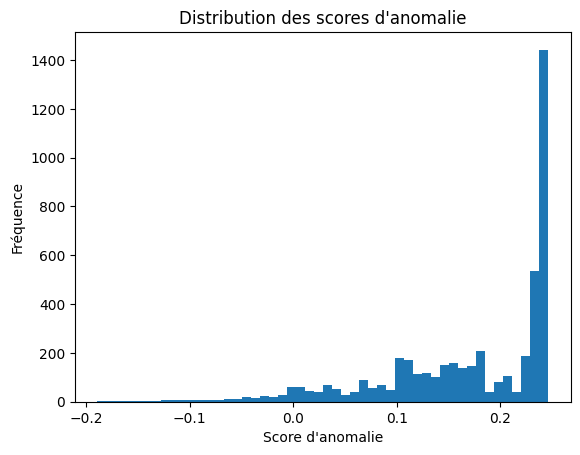

In [ ]:
# Afficher les anomalies
anomalies = df[df["Is_Anomaly"] == -1]
print(f"Nombre d'anomalies détectées : {len(anomalies)}")

# Exemple d'anomalie détectée
print(anomalies[["Time", "Source", "Destination", "Protocol", "Length"]].head())

# Visualiser les scores d'anomalie
import matplotlib.pyplot as plt
plt.hist(df["Anomaly_Score"], bins=50)
plt.xlabel("Score d'anomalie")
plt.ylabel("Fréquence")
plt.title("Distribution des scores d'anomalie")
plt.show()

In [ ]:
anomalies[["Time", "Source", "Destination", "Protocol", "Length"]].head()

,Time,Source,Destination,Protocol,Length
4,0.248580,6,10,4,1514
12,1.007027,6,31,4,54
19,1.405379,6,31,4,1466
20,1.582069,6,10,4,54
23,1.789947,10,6,4,85


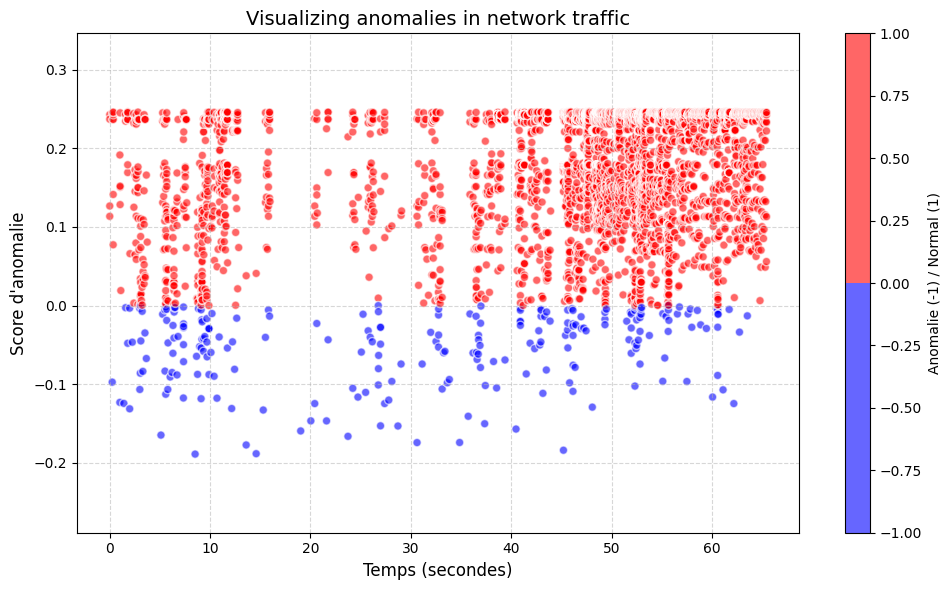

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Créer une palette de couleurs personnalisée (rouge pour les anomalies)
cmap = ListedColormap(["blue", "red"])  # 1 = normal (bleu), -1 = anomalie (rouge)

# Tracer le scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=df["Time"],
    y=df["Anomaly_Score"],
    c=df["Is_Anomaly"],
    cmap=cmap,
    alpha=0.6,
    edgecolors="w"
)

# Ajouter des labels et un titre
plt.xlabel("Temps (secondes)", fontsize=12)
plt.ylabel("Score d'anomalie", fontsize=12)
plt.title("Visualizing anomalies in network traffic", fontsize=14)
plt.colorbar(scatter, label="Anomalie (-1) / Normal (1)")

# Ajuster les limites de l'axe y pour mieux voir les anomalies
plt.ylim(df["Anomaly_Score"].min() - 0.1, df["Anomaly_Score"].max() + 0.1)

# Ajouter une grille
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

<ipython-input-23-e201f1142da3>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(["Time_Bucket", "Protocol"])["Anomaly_Score"].mean().reset_index()


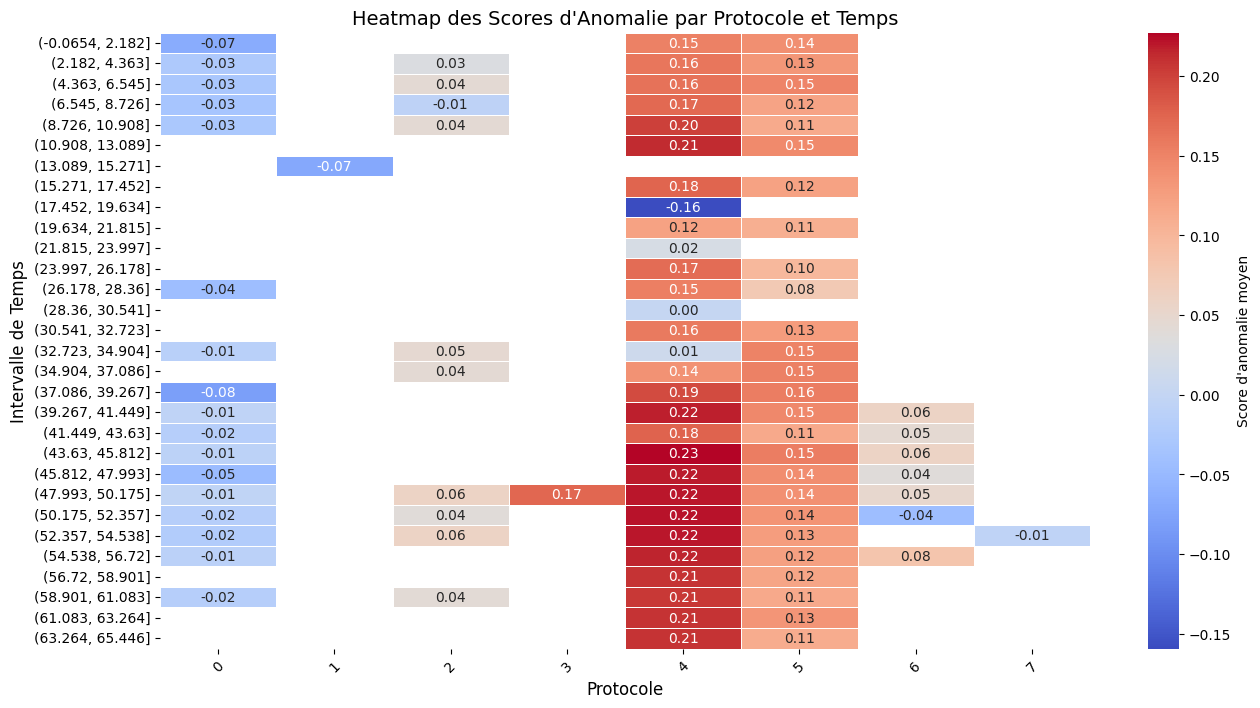

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Préparer les données
df["Time_Bucket"] = pd.cut(df["Time"], bins=30)  # 30 intervalles de temps
heatmap_data = df.groupby(["Time_Bucket", "Protocol"])["Anomaly_Score"].mean().reset_index()

# Pivoter pour la heatmap
heatmap_pivot = heatmap_data.pivot(index="Time_Bucket", columns="Protocol", values="Anomaly_Score")

# Tracer
plt.figure(figsize=(15, 8))
sns.heatmap(
    heatmap_pivot,
    cmap="coolwarm",
    cbar_kws={"label": "Score d'anomalie moyen"},
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Heatmap des Scores d'Anomalie par Protocole et Temps", fontsize=14)
plt.xlabel("Protocole", fontsize=12)
plt.ylabel("Intervalle de Temps", fontsize=12)
plt.xticks(rotation=45)
plt.show()

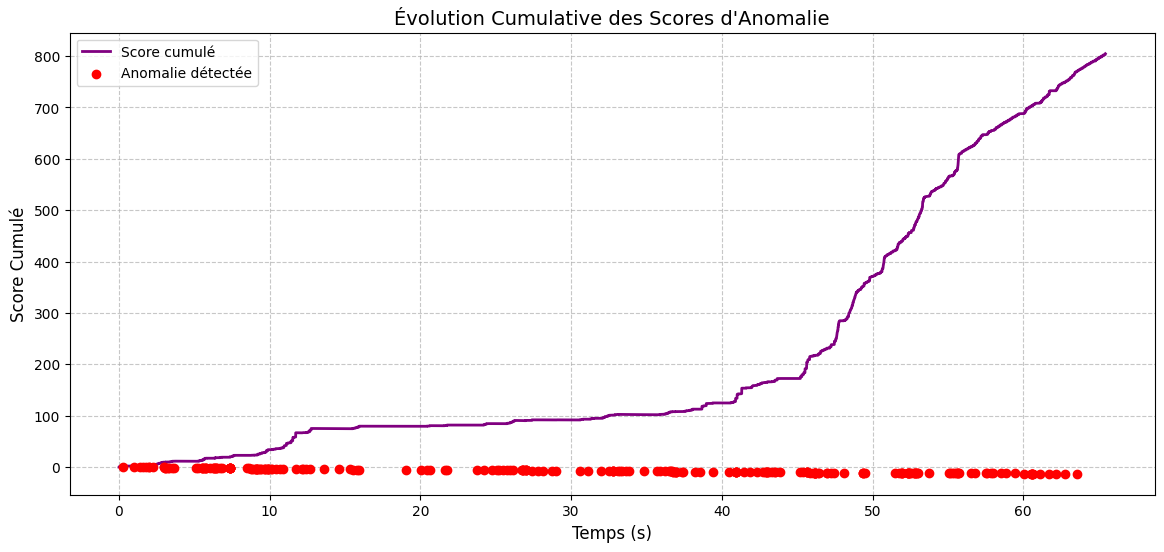

In [ ]:
# Trier par temps
df_sorted = df.sort_values("Time")

# Courbe cumulative
plt.figure(figsize=(14, 6))
plt.plot(
    df_sorted["Time"],
    df_sorted["Anomaly_Score"].cumsum(),
    color="purple",
    linewidth=2,
    label="Score cumulé"
)

# Ajouter des marqueurs pour les anomalies
anomaly_points = df_sorted[df_sorted["Is_Anomaly"] == -1]
plt.scatter(
    anomaly_points["Time"],
    anomaly_points["Anomaly_Score"].cumsum(),
    color="red",
    label="Anomalie détectée",
    zorder=5
)

plt.title("Évolution Cumulative des Scores d'Anomalie", fontsize=14)
plt.xlabel("Temps (s)", fontsize=12)
plt.ylabel("Score Cumulé", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

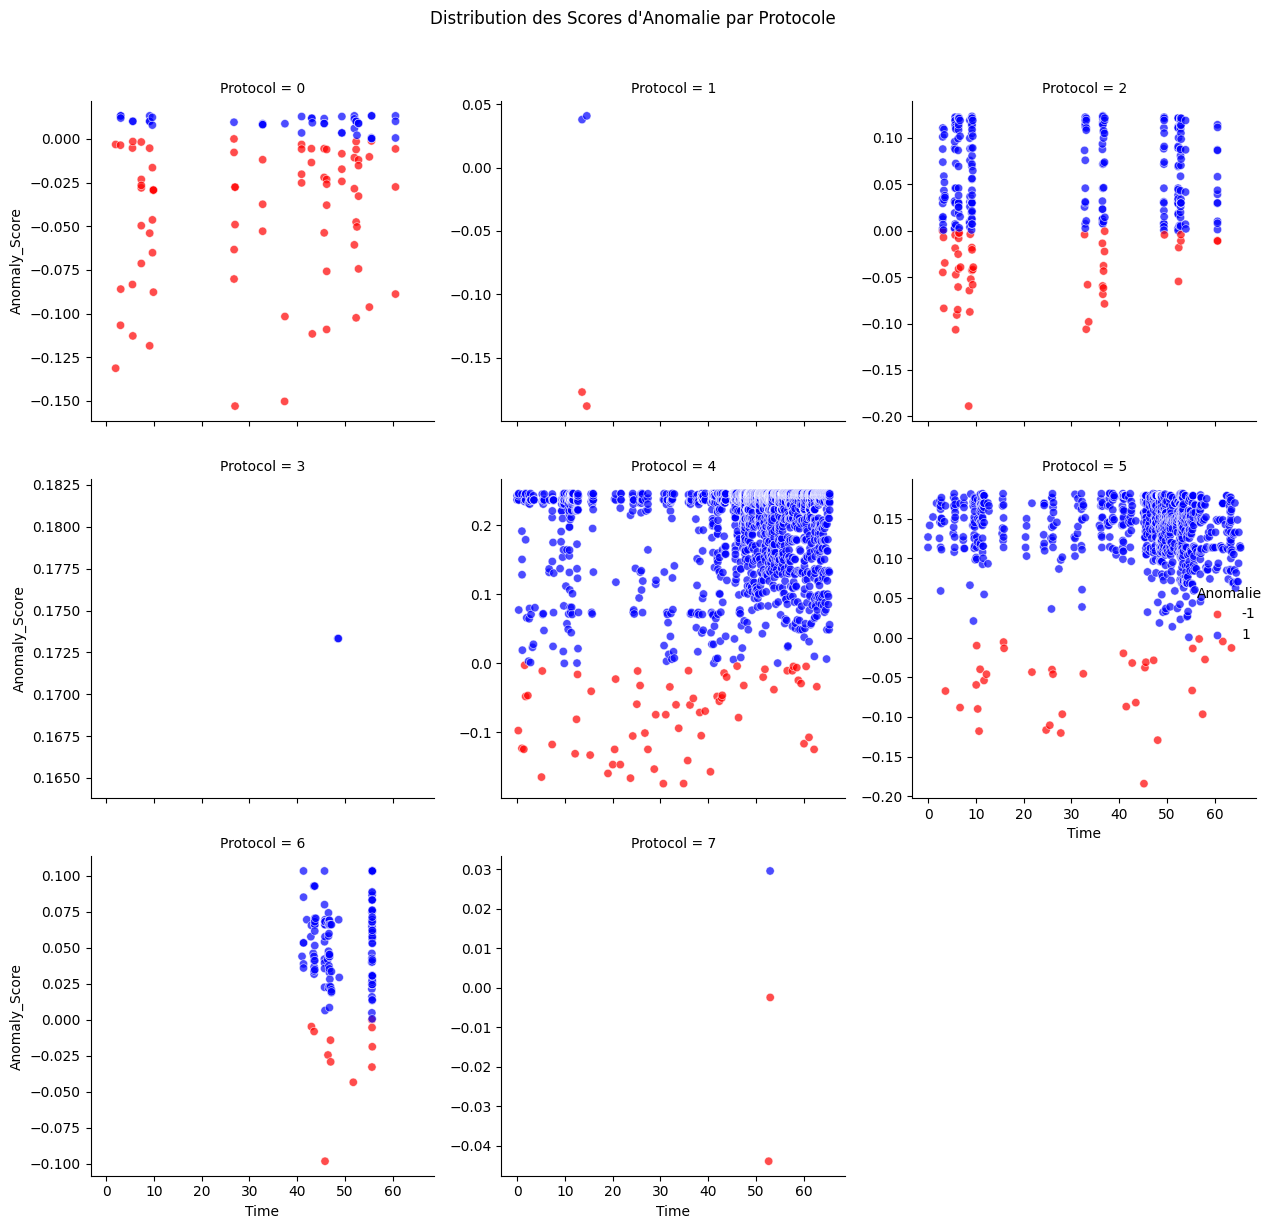

In [ ]:
g = sns.FacetGrid(
    df,
    col="Protocol",  # Colonnes = Protocoles (TCP, TLSv1.2, QUIC...)
    col_wrap=3,
    height=4,
    sharey=False
)
g.map_dataframe(
    sns.scatterplot,
    x="Time",
    y="Anomaly_Score",
    hue="Is_Anomaly",
    palette = {1: "blue", -1: "red"},
    alpha=0.7
)
g.add_legend(title="Anomalie")
plt.suptitle("Distribution des Scores d'Anomalie par Protocole", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter(
    df,
    x="Time",
    y="Anomaly_Score",
    color="Is_Anomaly",
    color_discrete_map={-1: "red", 1: "blue"},
    hover_data=["Source", "Destination", "Protocol", "Length"],
    title="Scores d'Anomalie avec Détails en Hover"
)
fig.update_layout(
    hoverlabel=dict(bgcolor="white", font_size=12),
    xaxis_title="Temps (s)",
    yaxis_title="Score d'anomalie"
)
fig.show()

In [ ]:
import pandas as pd
import re

# Load data
df = pd.read_csv("Trafi-1.csv")

# Extract flags from 'Info'
flags = ['SYN', 'ACK', 'RST', 'Retransmission', 'FIN']
for flag in flags:
    df[flag] = df['Info'].apply(lambda x: 1 if re.search(flag, str(x)) else 0)

# One-hot encode 'Protocol'
df = pd.get_dummies(df, columns=['Protocol'])

FileNotFoundError: [Errno 2] No such file or directory: 'Trafi-1.csv'

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Select features
features = ['Length'] + flags + list(df.filter(like='Protocol_').columns)
X = df[features]

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(X_scaled)

NameError: name 'flags' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest

# Charger et prétraiter les données
df = pd.read_csv("trafic.csv")
df = df.drop(["No.", "Info"], axis=1)

# Encodage des catégories
label_encoders = {}
for col in ["Source", "Destination", "Protocol"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature engineering
df["Time"] = df["Time"].astype(float)
df["Time_Interval"] = df["Time"].diff().fillna(0)

# Normalisation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[["Length", "Time_Interval"]])
X = pd.DataFrame(scaled_features, columns=["Length", "Time_Interval"])
X["Protocol"] = df["Protocol"]

# Entraînement du modèle
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X)

# Prédictions
df["Anomaly_Score"] = model.decision_function(X)
df["Is_Anomaly"] = model.predict(X)

# Conversion des labels pour l'interprétation
df["Anomaly_Label"] = df["Is_Anomaly"].map({1: "Normal", -1: "Anomalie"})
df["Protocol"] = label_encoders["Protocol"].inverse_transform(df["Protocol"])  # Décodage du protocole

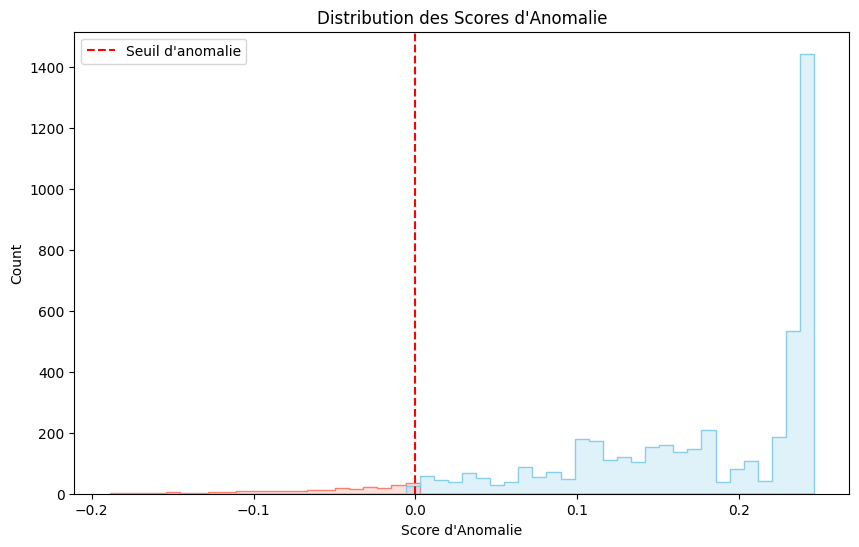

In [ ]:
# Visualisation 1: Distribution des scores d'anomalie
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="Anomaly_Score", hue="Anomaly_Label", element="step",
             palette={"Normal": "skyblue", "Anomalie": "salmon"}, bins=50)
plt.axvline(x=df[df["Anomaly_Label"] == "Normal"]["Anomaly_Score"].min(),
            color='red', linestyle='--', label='Seuil d\'anomalie')
plt.title("Distribution des Scores d'Anomalie")
plt.xlabel("Score d'Anomalie")
plt.legend()
plt.show()

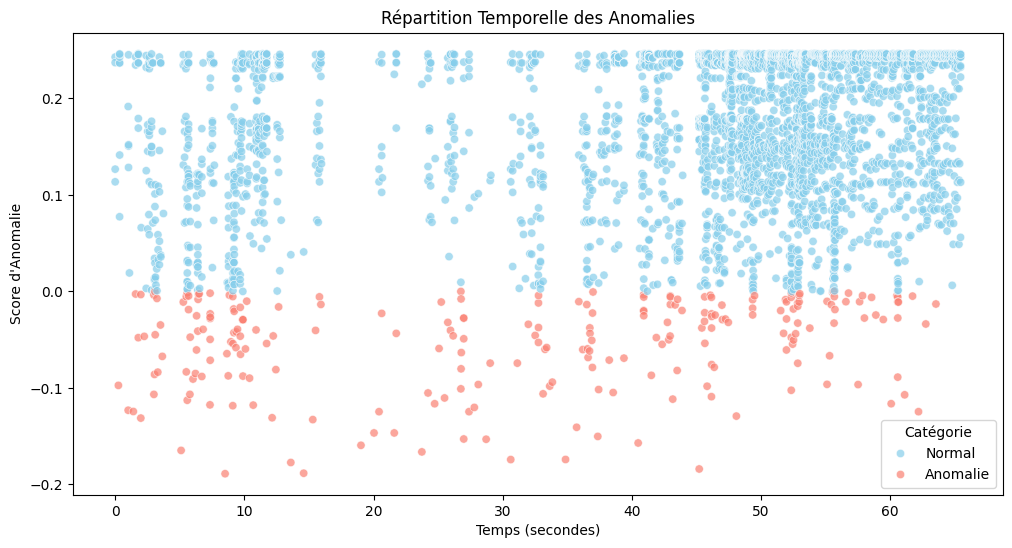

In [ ]:
# Visualisation 2: Anomalies dans le temps
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="Time", y="Anomaly_Score", hue="Anomaly_Label",
                palette={"Normal": "skyblue", "Anomalie": "salmon"}, alpha=0.7)
plt.title("Répartition Temporelle des Anomalies")
plt.ylabel("Score d'Anomalie")
plt.xlabel("Temps (secondes)")
plt.legend(title="Catégorie")
plt.show()

<ipython-input-31-49b3a89714c3>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




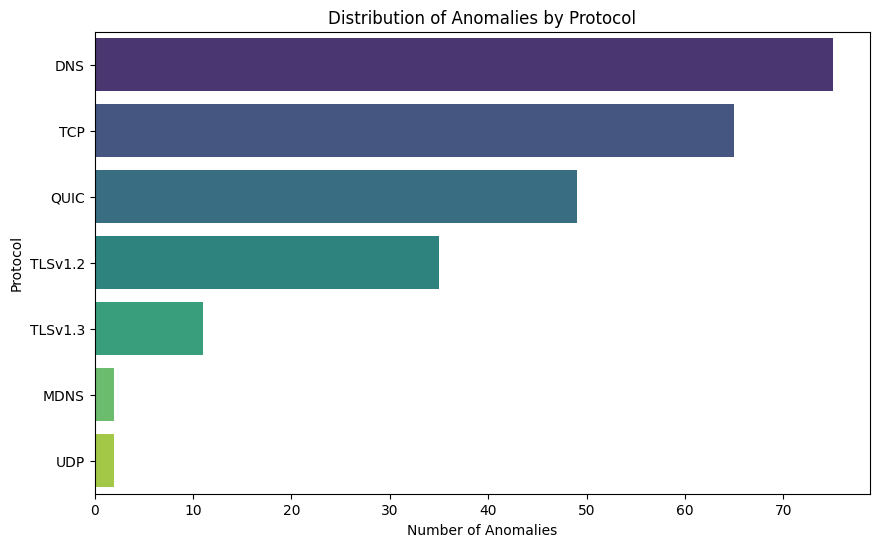

In [ ]:
# Visualisation 3: Analyse des protocoles
plt.figure(figsize=(10, 6))
protocol_counts = df[df["Anomaly_Label"] == "Anomalie"]["Protocol"].value_counts()
sns.barplot(x=protocol_counts.values, y=protocol_counts.index, palette="viridis")
plt.title("Distribution of Anomalies by Protocol")
plt.xlabel("Number of Anomalies")
plt.ylabel("Protocol")
plt.show()

<ipython-input-52-ade0df2fa4d4>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-52-ade0df2fa4d4>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




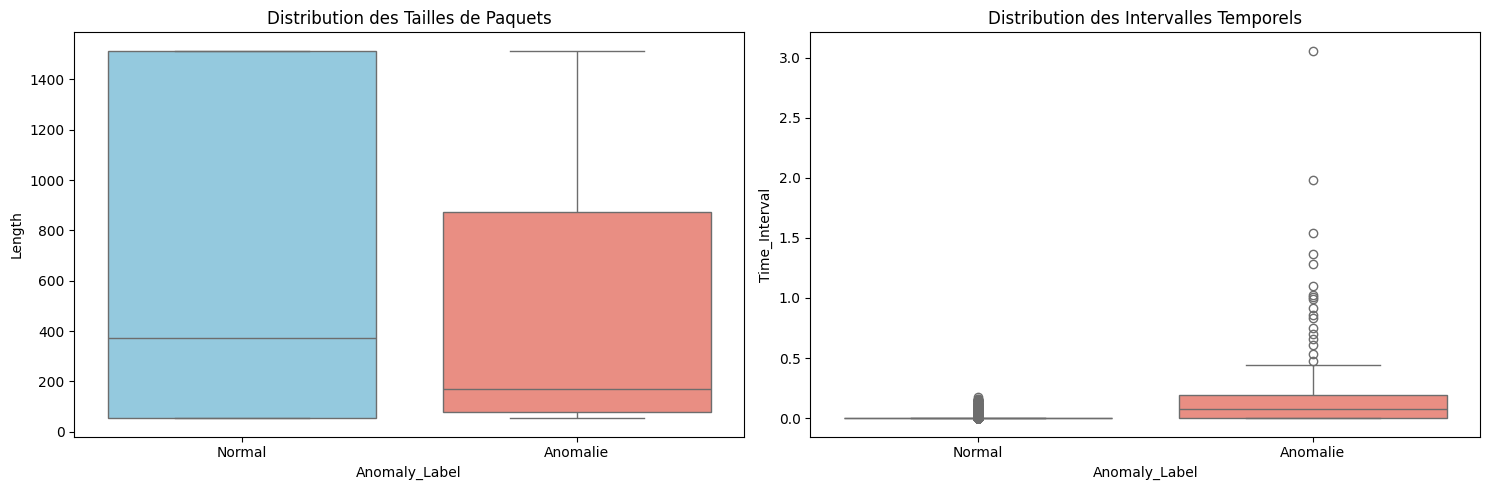

In [ ]:
# Visualisation 4: Comparaison des caractéristiques
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(ax=axes[0], x="Anomaly_Label", y="Length", data=df,
            palette={"Normal": "skyblue", "Anomalie": "salmon"})
axes[0].set_title("Distribution des Tailles de Paquets")

sns.boxplot(ax=axes[1], x="Anomaly_Label", y="Time_Interval", data=df,
            palette={"Normal": "skyblue", "Anomalie": "salmon"})
axes[1].set_title("Distribution des Intervalles Temporels")

plt.tight_layout()
plt.show()

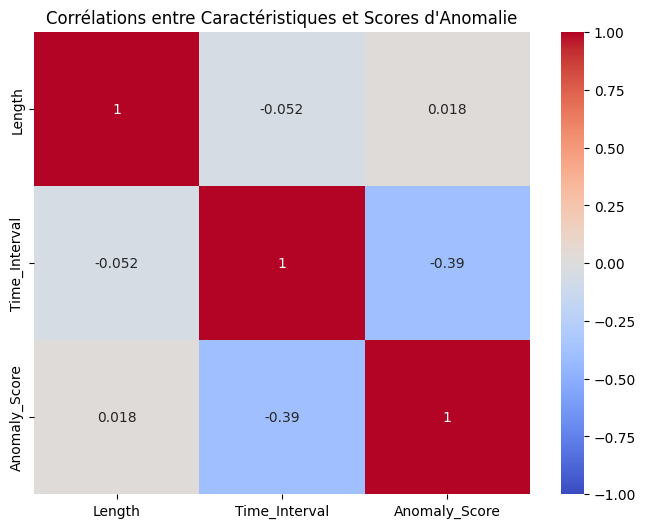

In [ ]:
# Visualisation 5: Matrice de corrélation
corr_matrix = df[["Length", "Time_Interval", "Anomaly_Score"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Corrélations entre Caractéristiques et Scores d'Anomalie")
plt.show()

In [ ]:
# Performance Evaluation Framework

# 1. Analyse de la stabilité du modèle
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour valider la séparation des clusters
silhouette = silhouette_score(X, df["Is_Anomaly"])
print(f"Silhouette Score: {silhouette:.2f}")

# 2. Validation temporelle des anomalies
anomaly_time_dist = df[df["Is_Anomaly"] == -1]["Time"].diff().describe()
print("\nDistribution temporelle des anomalies:")
print(anomaly_time_dist)

Silhouette Score: 0.57

Distribution temporelle des anomalies:
count    238.000000
mean       0.265902
std        0.392197
min        0.000000
25%        0.016838
50%        0.141693
75%        0.324236
max        3.102871
Name: Time, dtype: float64


In [ ]:
# 6. Validation manuelle des top anomalies
top_anomalies = df.sort_values("Anomaly_Score").head(10)[["Time", "Source", "Destination", "Protocol", "Length"]]
print("\nTop 10 des anomalies détectées:")
print(top_anomalies)


Top 10 des anomalies détectées:
           Time  Source  Destination Protocol  Length
237    8.508408       6           17     QUIC     386
584   14.592364       6           19     MDNS      85
1278  45.209211      10            6  TLSv1.2     422
582   13.596071       6           19     MDNS      85
730   30.620492       6           10      TCP    1514
825   34.862946       6            0      TCP    1454
638   23.739624       6           26      TCP      66
108    5.103325       6           10      TCP      66
617   19.026845       6            0      TCP      54
991   40.483737       6           10      TCP      66


In [ ]:
import numpy as np

# Extraire tous les arbres de la forêt
estimators = model.estimators_

# Calculer les importances moyennes
feature_importances = np.zeros(X.shape[1])
for tree in estimators:
    feature_importances += tree.feature_importances_

feature_importances /= len(estimators)

# Créer un DataFrame pour visualisation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(importance_df)

         Feature  Importance
1  Time_Interval    0.510169
0         Length    0.349302
2       Protocol    0.140529


In [ ]:
# Performance Evaluation Framework

# 1. Analyse de la stabilité du modèle
from sklearn.metrics import silhouette_score

# Calcul du score de silhouette pour valider la séparation des clusters
silhouette = silhouette_score(X, df["Is_Anomaly"])
print(f"Silhouette Score: {silhouette:.2f}")

# 2. Validation temporelle des anomalies
anomaly_time_dist = df[df["Is_Anomaly"] == -1]["Time"].diff().describe()
print("\nDistribution temporelle des anomalies:")
print(anomaly_time_dist)

# 3. Analyse d'importance des caractéristiques
# Extraire tous les arbres de la forêt
estimators = model.estimators_

# Calculer les importances moyennes
feature_importances = np.zeros(X.shape[1])
for tree in estimators:
    feature_importances += tree.feature_importances_

feature_importances /= len(estimators)

# Créer un DataFrame pour visualisation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# 6. Validation manuelle des top anomalies
top_anomalies = df.sort_values("Anomaly_Score").head(10)[["Time", "Source", "Destination", "Protocol", "Length"]]
print("\nTop 10 des anomalies détectées:")
print(top_anomalies)

Silhouette Score: 0.57

Distribution temporelle des anomalies:
count    238.000000
mean       0.265902
std        0.392197
min        0.000000
25%        0.016838
50%        0.141693
75%        0.324236
max        3.102871
Name: Time, dtype: float64

Top 10 des anomalies détectées:
           Time  Source  Destination Protocol  Length
237    8.508408       6           17     QUIC     386
584   14.592364       6           19     MDNS      85
1278  45.209211      10            6  TLSv1.2     422
582   13.596071       6           19     MDNS      85
730   30.620492       6           10      TCP    1514
825   34.862946       6            0      TCP    1454
638   23.739624       6           26      TCP      66
108    5.103325       6           10      TCP      66
617   19.026845       6            0      TCP      54
991   40.483737       6           10      TCP      66


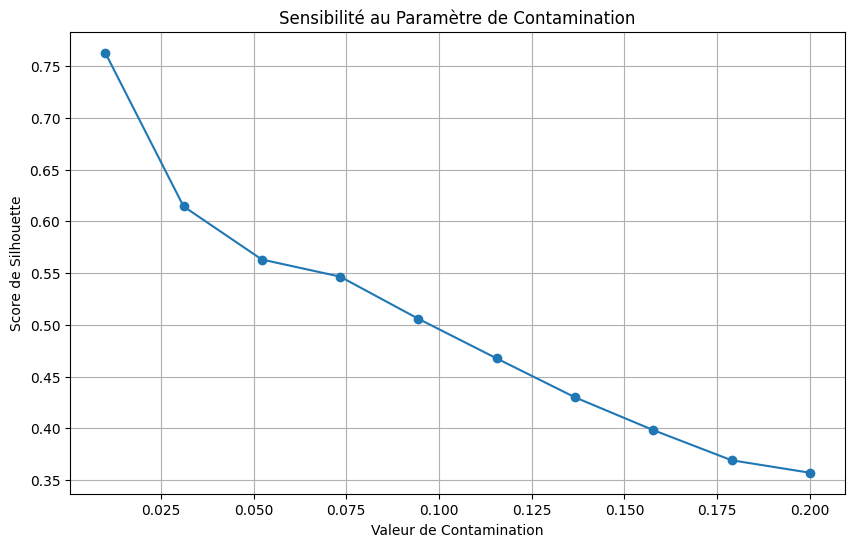

In [ ]:
# 5. Analyse de sensibilité au paramètre de contamination
contamination_range = np.linspace(0.01, 0.2, 10)
results = []

for c in contamination_range:
    model = IsolationForest(contamination=c, random_state=42)
    model.fit(X)
    score = silhouette_score(X, model.predict(X))
    results.append(score)

plt.figure(figsize=(10, 6))
plt.plot(contamination_range, results, marker='o')
plt.title("Sensibilité au Paramètre de Contamination")
plt.xlabel("Valeur de Contamination")
plt.ylabel("Score de Silhouette")
plt.grid(True)
plt.show()

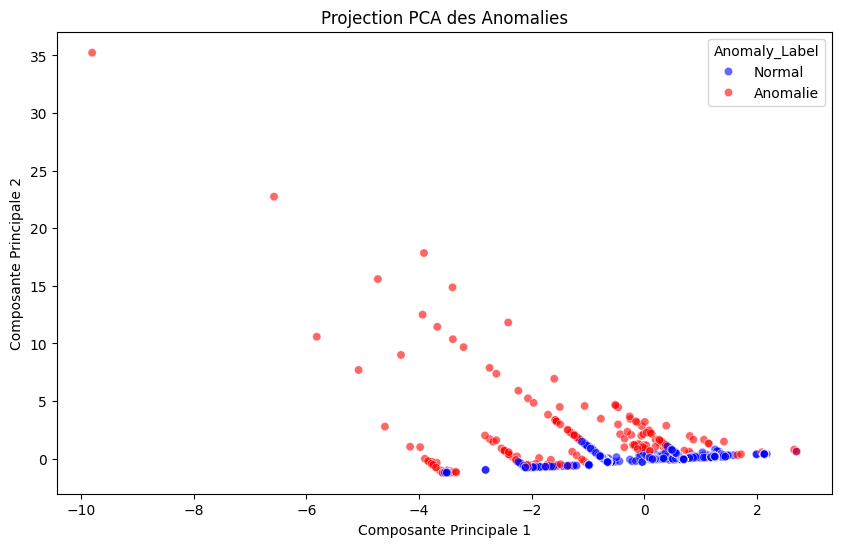

In [ ]:
# 4. Évaluation de la cohérence des clusters
from sklearn.decomposition import PCA

# Réduction de dimension
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["Anomaly_Label"],
                palette={"Normal": "blue", "Anomalie": "red"}, alpha=0.6)
plt.title("Projection PCA des Anomalies")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.show()

<ipython-input-64-cbe369905a16>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




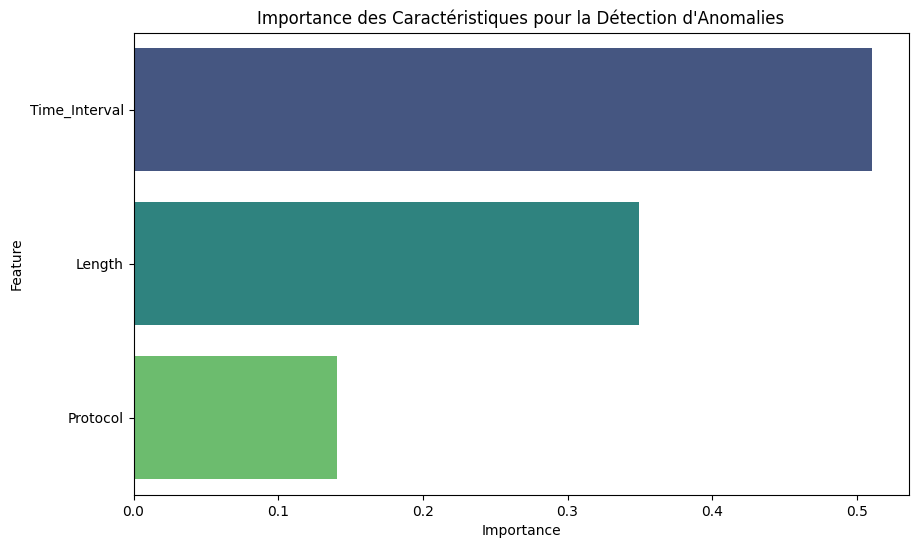

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Importance des Caractéristiques pour la Détection d'Anomalies")
plt.show()


In [ ]:
import numpy as np

# Extraire tous les arbres de la forêt
estimators = model.estimators_

# Calculer les importances moyennes
feature_importances = np.zeros(X.shape[1])
for tree in estimators:
    feature_importances += tree.feature_importances_

feature_importances /= len(estimators)

# Créer un DataFrame pour visualisation
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(importance_df)

         Feature  Importance
1  Time_Interval    0.510169
0         Length    0.349302
2       Protocol    0.140529
